# **PREDICTORS OF HEALTH INSURANCE CHARGES**

## Objectives

* The primary goal of this analysis was to explore how personal attributes (i.e., age and sex) and geographic factors influence healthcare insurance cost and develop predictive models for estimating healthcare expenses.

## Analysis questions
The analysis was driven by the following key questions: 
* Does the health insurance charges vary by individual characteristics (i.e., sex, smoking status, bmi)?
* Is the location (geographical regions) associated with health insurance charges?
* What are the key predictors of insurance charges?

## Analytical plan
* Load data and package
* Perform data exploration
* Conduct data manipulation, including transformation
* Visualize health insurance charges by sex, smoking status, bmi and children to examine if there are obvious differences across the individual characteristics
* Examine graphically if insurance charges vary by location (region) 
* Develop and test a predictive model for insurance health charges

## Data

* I used publicly available data, which was accessed from Kaggle https://www.kaggle.com/datasets/willianoliveiragibin/healthcare-insurance on 14 October 2025



---

# 1. Change working directory

In [ ]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\Administrator\\OneDrive\\Documents'

Make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [54]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Administrator\\OneDrive'

# 2. Data extraction

## *2.1. Import packages*

In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from feature_engine.selection import DropFeatures, SelectByShuffling
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer, BoxCoxTransformer
from feature_engine.discretisation import EqualWidthDiscretiser, EqualFrequencyDiscretiser, ArbitraryDiscretiser
from feature_engine.outliers import Winsorizer, ArbitraryOutlierCapper
import warnings
warnings.filterwarnings('ignore')

## *2.2. Load Data*

In [56]:
df = pd.read_csv('insurance.csv') # Load the dataset
print(f"Shape of the DataFrame: {df.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'insurance.csv'

# 3. Data exploration

In [8]:
df.head(5)  # First 5 rows of the DataFrame

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
df.tail(5)  # Last 5 rows of the DataFrame

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [10]:
df.info() # Summary of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [11]:
df.describe() # Statistical summary of numerical columns

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [12]:
duplicate_rows = df.duplicated().sum() # Count of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 1


In [13]:
df.isnull().sum() # Count of missing values in each column

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [14]:
# Show unique values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    unique_values = df[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values: {unique_values}")

Column 'sex' has 2 unique values: ['female' 'male']
Column 'smoker' has 2 unique values: ['yes' 'no']
Column 'region' has 4 unique values: ['southwest' 'southeast' 'northwest' 'northeast']


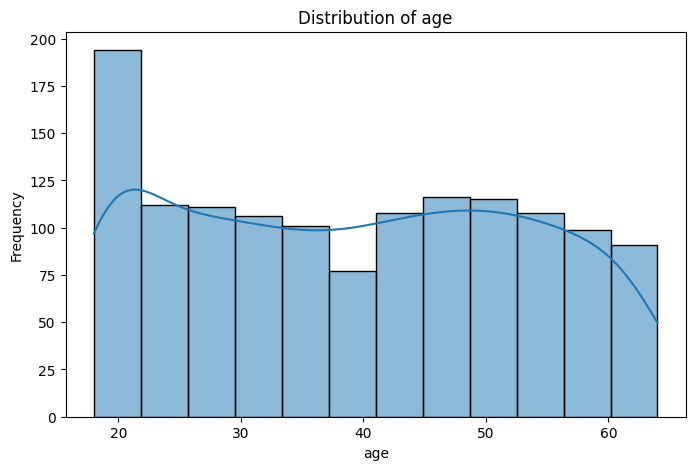

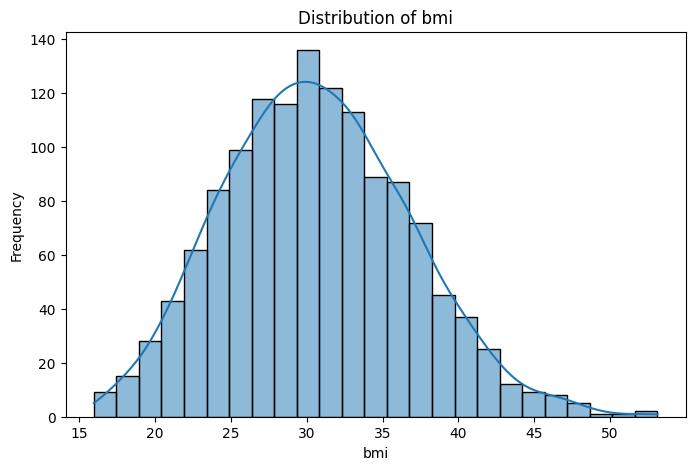

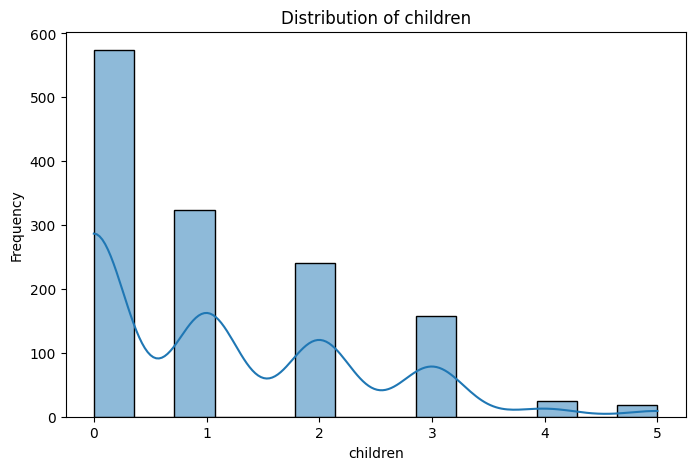

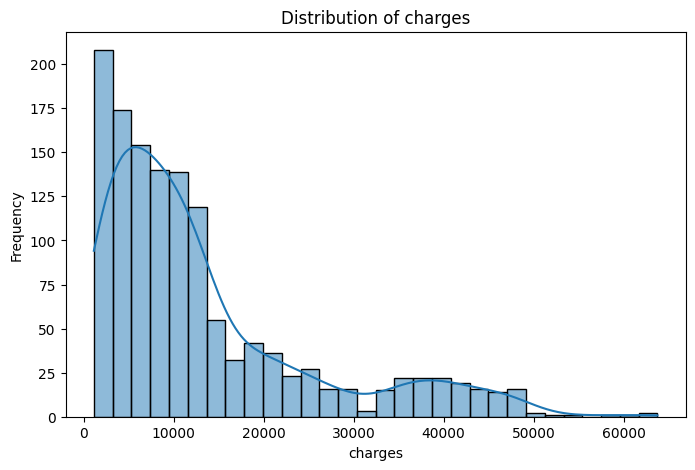

In [15]:
# Check normality of non-object columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

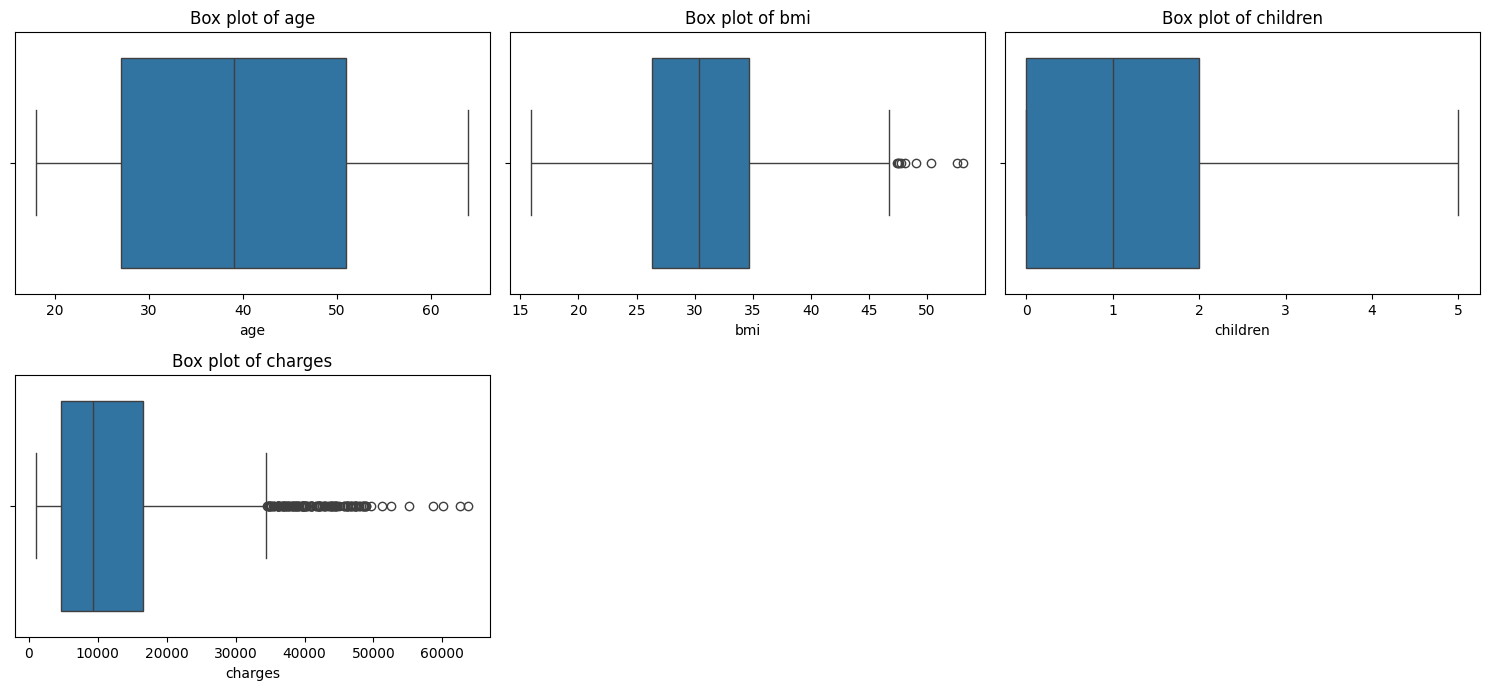

In [16]:
# Check outliers using box plots subplots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

In [17]:
# Check outliers using IQR method
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"Column '{col}' has {outliers.shape[0]} outliers")

Column 'age' has 0 outliers
Column 'bmi' has 9 outliers
Column 'children' has 0 outliers
Column 'charges' has 139 outliers


In [18]:
# Check column labels before encoding

print("Columns before encoding:", df.columns.tolist())

Columns before encoding: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


# 4. Data manipulation

## *4.1. Cleaning*

In [19]:
# Drop duplicate rows and count number of rows dropped

if duplicate_rows > 0:
    df = df.drop_duplicates()
    print(f"{duplicate_rows} duplicate row dropped. New shape of DataFrame: {df.shape}")

1 duplicate row dropped. New shape of DataFrame: (1337, 7)


In [20]:
# Round bmi column to 2 decimal places

df['bmi'] = df['bmi'].round(2)

In [21]:
# Round charges column to 2 decimal places

df['charges'] = df['charges'].round(2)
df.sample(5)  # Display 5 random rows to verify changes

,age,sex,bmi,children,smoker,region,charges
1146,60,male,32.80,0,yes,southwest,52590.83
351,50,female,25.60,0,no,southwest,8932.08
1305,24,female,27.72,0,no,southeast,2464.62
1331,23,female,33.40,0,no,southwest,10795.94
426,38,female,27.26,1,no,northeast,6555.07


In [22]:
# Save the cleaned DataFrame to a new CSV file

df.to_csv('cleaned_insurance.csv', index=False)

df_cleaned = pd.read_csv('cleaned_insurance.csv')
df_cleaned.sample(5)  # Verify the cleaned data

,age,sex,bmi,children,smoker,region,charges
972,19,female,40.50,0,no,southwest,1759.34
396,43,female,34.40,3,no,southwest,8522.00
426,38,female,27.26,1,no,northeast,6555.07
94,64,female,31.30,2,yes,southwest,47291.06
2,28,male,33.00,3,no,southeast,4449.46


## *4.2. Transformation*

In [23]:
# Outlier treatment for 'bmi' and 'charges' using IQR method

from feature_engine.outliers import Winsorizer # Import Winsorizer to handle outliers
from sklearn.pipeline import Pipeline

# Define a pipeline to handle outliers
pipeline = Pipeline([
            ( 'winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', variables=['bmi', 'charges']) )
])

df_transformed = pipeline.fit_transform(df_cleaned)
df_transformed.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


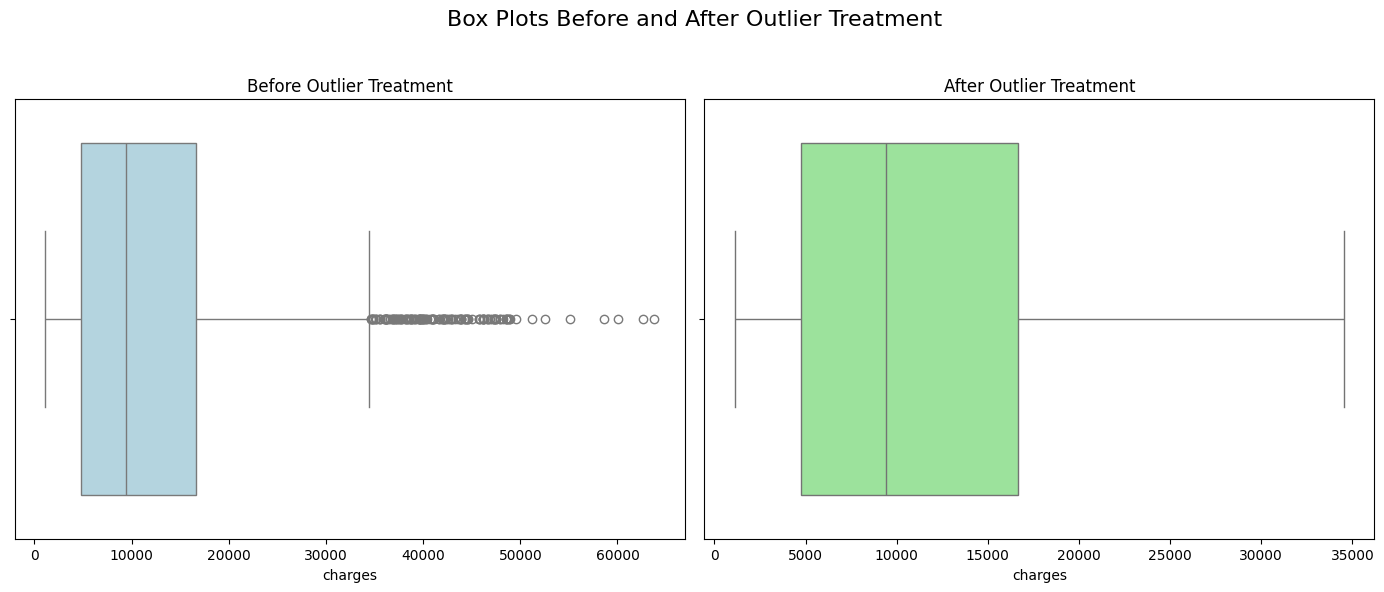

In [24]:
# Check outliers before and after treatment using box plots for charges

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Box Plots Before and After Outlier Treatment", fontsize=16)
# Before treatment
sns.boxplot(x=df_cleaned['charges'], ax=axes[0], color='lightblue')
axes[0].set_title("Before Outlier Treatment")   
# After treatment
sns.boxplot(x=df_transformed['charges'], ax=axes[1], color='lightgreen')
axes[1].set_title("After Outlier Treatment")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


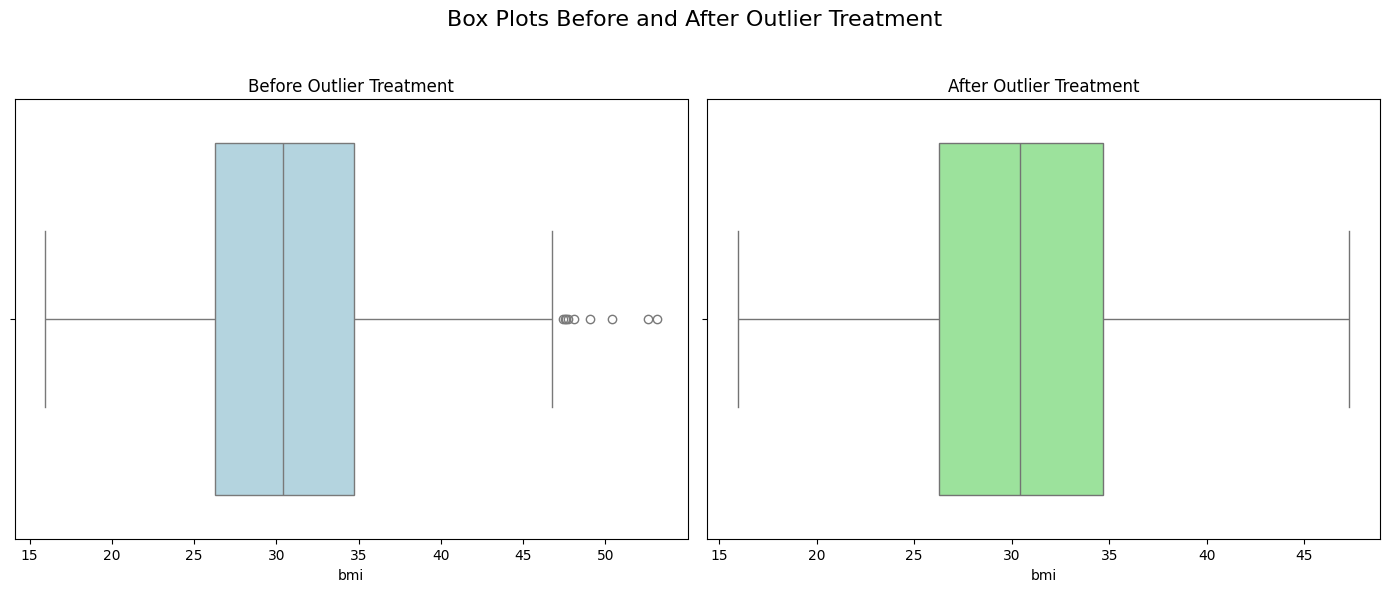

In [25]:
# Check outliers before and after treatment using box plots for bmi

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Box Plots Before and After Outlier Treatment", fontsize=16)
# Before treatment
sns.boxplot(x=df_cleaned['bmi'], ax=axes[0], color='lightblue')
axes[0].set_title("Before Outlier Treatment")
# After treatment
sns.boxplot(x=df_transformed['bmi'], ax=axes[1], color='lightgreen')
axes[1].set_title("After Outlier Treatment")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
# Categorizing the bmi values as underweight,normal,overweight and obesity

def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 24.9:
        return 'healthy weight'
    elif 25 <= bmi < 29.9:
        return 'overweight'
    else:
        return 'obesity'

df_transformed['bmi_category'] = df_transformed['bmi'].apply(categorize_bmi)
print(df_transformed[['bmi_category', 'bmi']].sample(5))  # Display sample of new column

        bmi_category    bmi
1114         obesity  32.67
819          obesity  33.70
360          obesity  32.30
990       overweight  27.84
970   healthy weight  23.56


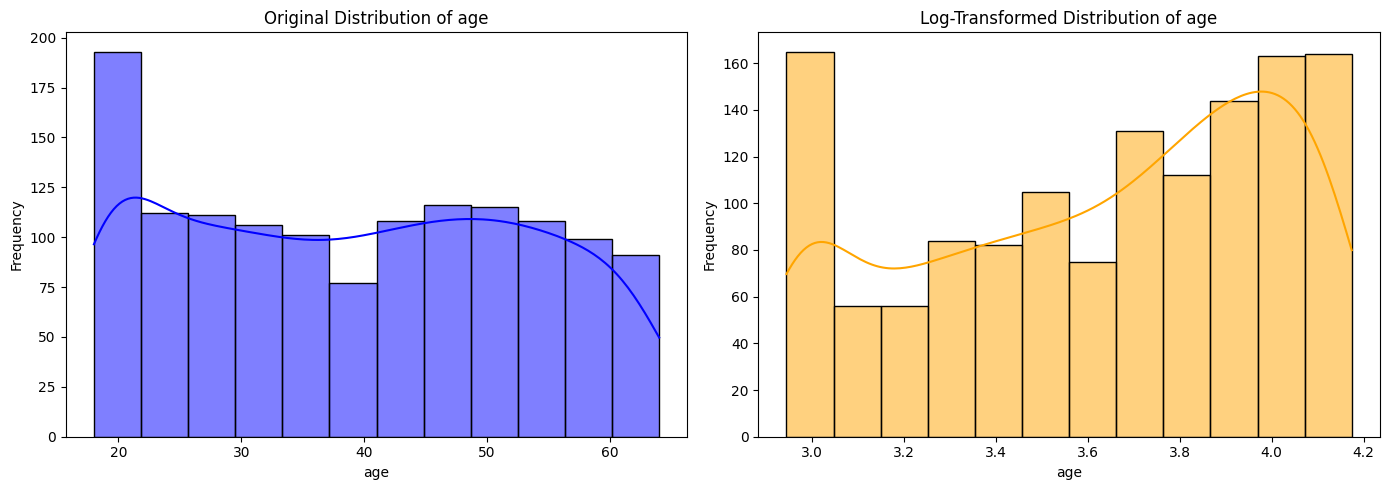

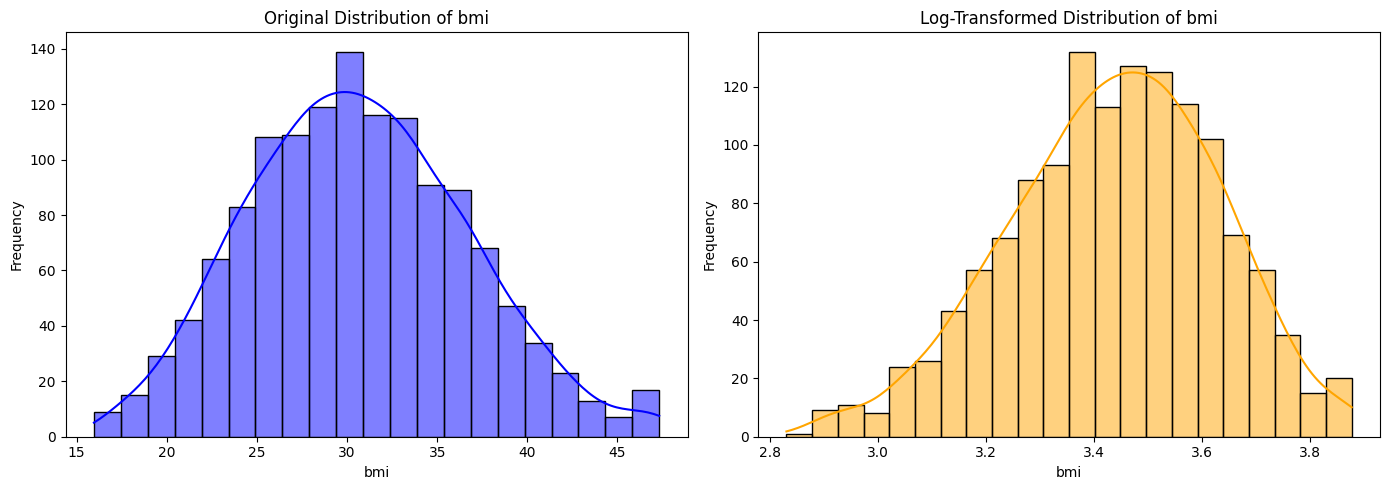

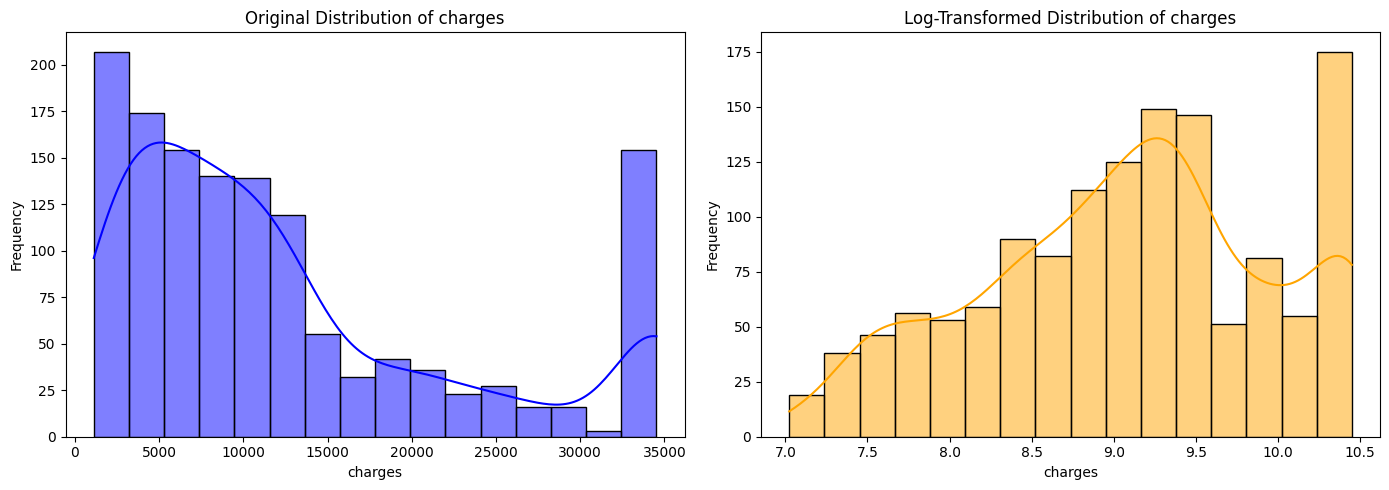

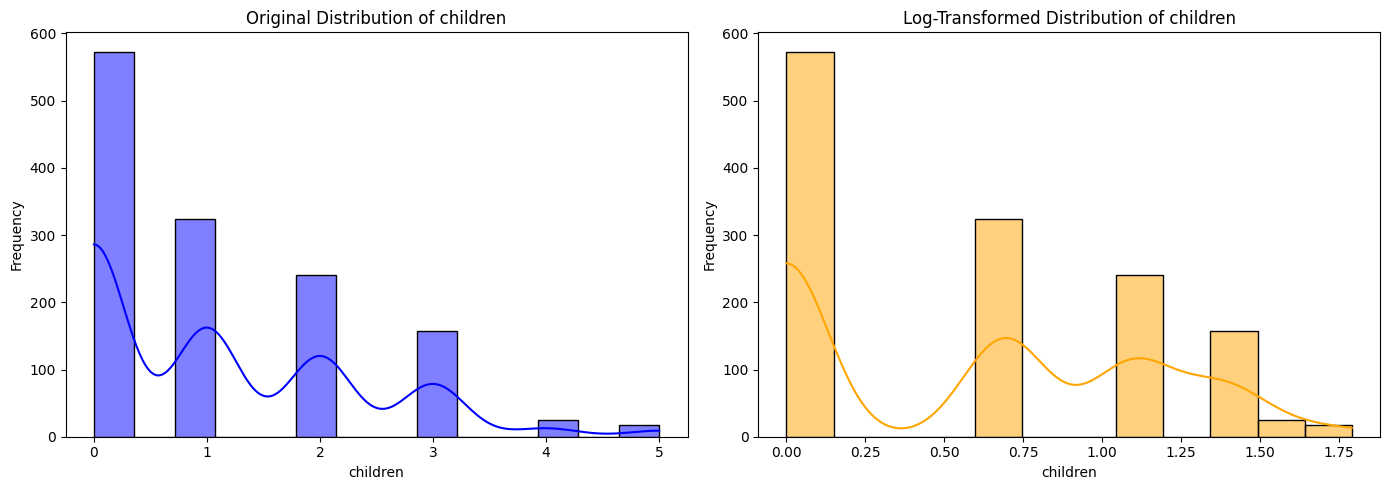

In [27]:
# Normalize numerical features (age, bmi, charges, children) through log transformation

df_logged = df_transformed.copy()  # Create a copy to avoid modifying the original DataFrame

for col in ['age', 'bmi', 'charges', 'children']:
    df_logged[col] = np.log1p(df_logged[col])  # log1p is used to handle zero values
    
# Check normality before and after log transformation for numerical columns using histplots

for col in ['age', 'bmi', 'charges', 'children']:
    plt.figure(figsize=(14, 5))

    # Before log transformation
    plt.subplot(1, 2, 1)
    sns.histplot(df_transformed[col], kde=True, color='blue')
    plt.title(f'Original Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # After log transformation
    plt.subplot(1, 2, 2)
    sns.histplot(df_logged[col], kde=True, color='orange')
    plt.title(f'Log-Transformed Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [28]:
# Encode categorical variables (sex, smoker, region)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import DropMissingData

# Define the pipeline using feature-engine's OneHotEncoder on categorical columns sex, smoker, region

pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(variables=['sex', 'smoker', 'region'], drop_last=True)),
])

df_encoded = pipeline.fit_transform(df_transformed)
df_encoded.sample(5)  # Display 5 random rows to verify changes

,age,bmi,children,charges,bmi_category,sex_female,smoker_yes,region_southwest,region_southeast,region_northwest
785,60,36.96,0,12741.17,obesity,0,0,0,0,0
1289,38,19.95,2,7133.90,healthy weight,1,0,0,0,0
263,19,36.96,0,34524.79,obesity,0,1,0,0,1
173,35,34.80,1,5246.05,obesity,1,0,1,0,0
729,35,24.42,3,19362.00,healthy weight,0,1,0,1,0


# 5. Data analysis & visualization

## *5.1. Health insurance charges and individual characteristics*

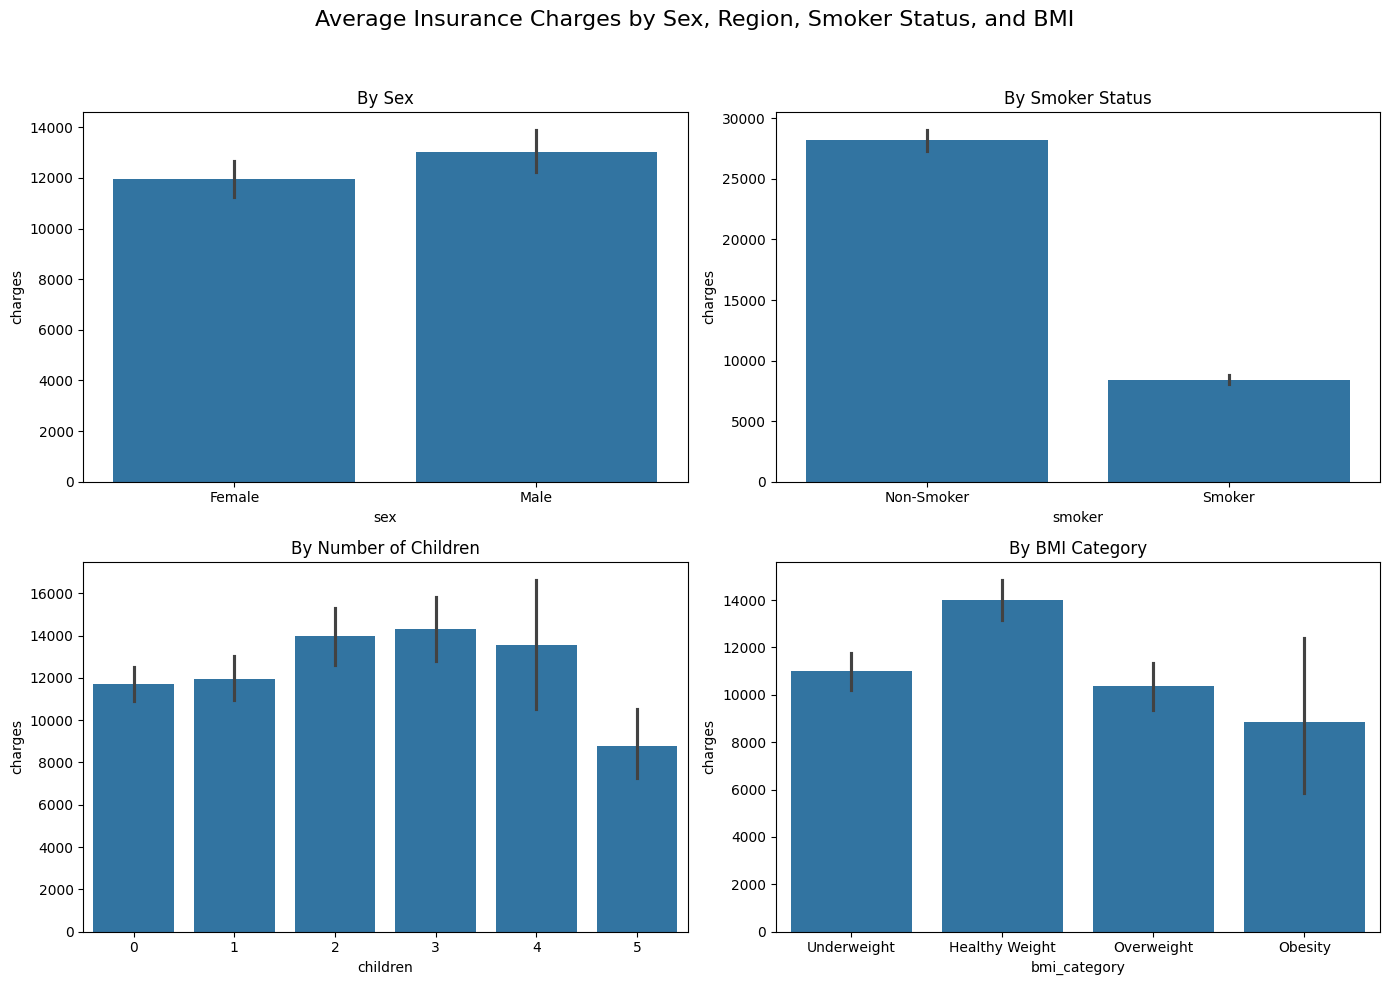

In [29]:
# Assessing relationships between individual attributes and insurance charges using bar charts

df = df_transformed # Use the transformed DataFrame for analysis

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Average Insurance Charges by Sex, Region, Smoker Status, and BMI", fontsize=16)

# Sex
sns.barplot(x='sex', y='charges', data=df, ax=axes[0, 0])
axes[0, 0].set_title("By Sex")
axes[0, 0].set_xticklabels(['Female', 'Male'])

# Smoker
sns.barplot(x='smoker', y='charges', data=df, ax=axes[0, 1])
axes[0, 1].set_title("By Smoker Status")
axes[0, 1].set_xticklabels(['Non-Smoker', 'Smoker'])

# Children
sns.barplot(x='children', y='charges', data=df, ax=axes[1, 0])
axes[1, 0].set_title("By Number of Children")
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# BMI Category
sns.barplot(x='bmi_category', y='charges', data=df, ax=axes[1, 1])
axes[1, 1].set_title("By BMI Category")
axes[1, 1].set_xticklabels(['Underweight', 'Healthy Weight', 'Overweight', 'Obesity'])

plt.tight_layout(rect=[0, 0, 1, 0.95])
colour = sns.color_palette("husl", 4)
plt.show()

In [30]:
# Compute correlation between numerical columns

df_rr = df_logged.filter(['age', 'bmi', 'children', 'charges']) # Use only numerical columns for correlation
df_corr = df_rr.corr(method='pearson')
df_corr

,age,bmi,children,charges
age,1.000000,0.111383,0.100480,0.542095
bmi,0.111383,1.000000,0.016348,0.123360
children,0.100480,0.016348,1.000000,0.173626
charges,0.542095,0.123360,0.173626,1.000000


In [31]:
# Visualize the correlation matrix using a plotly heatmap

fig = px.imshow(df_corr, text_auto=True, aspect="auto", color_continuous_scale='Viridis',
                title='Correlation Matrix Heatmap (Interactive)')
fig.show()


## *5.2.  Health insurance charges and location (geographical regions)*

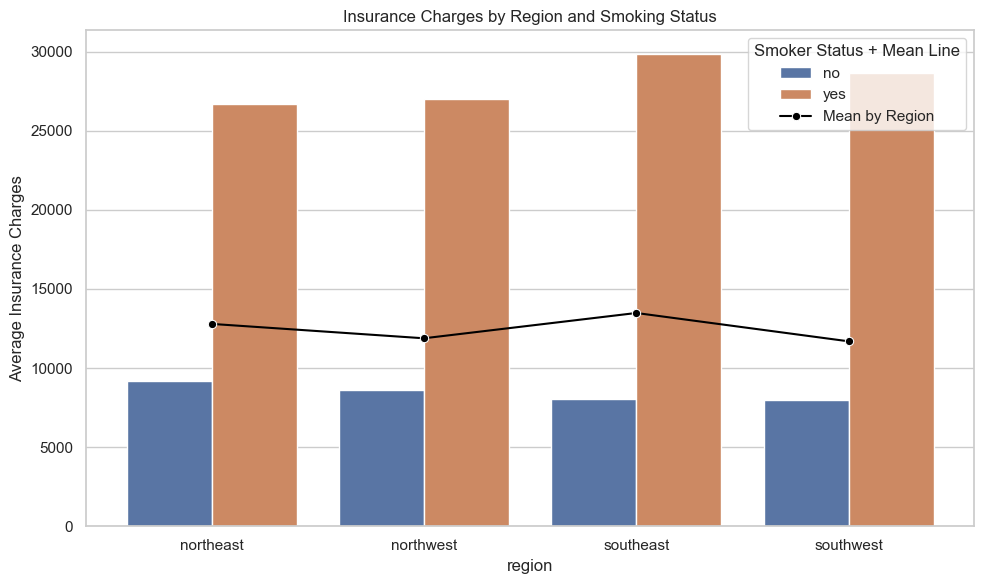

In [32]:
# Combined bar and line plot to show average charges by region and smoker status, with mean line per region

df = df_transformed # Use the transformed DataFrame for analysis

grouped = df.groupby(['region', 'smoker'])['charges'].mean().reset_index() #  Grouped data for bar plot

region_means = df.groupby('region')['charges'].mean().reset_index() # Mean charges per region (for line plot)

sns.set(style="whitegrid") # Set seaborn style

fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot: average charges by region and smoker
sns.barplot(x='region', y='charges', hue='smoker', data=grouped, ax=ax)
ax.set_ylabel("Average Insurance Charges")
ax.set_title("Insurance Charges by Region and Smoking Status")

# Line plot: mean charges per region
sns.lineplot(x='region', y='charges', data=region_means, marker='o', color='black', label='Mean by Region', ax=ax)

# Add legend and labels
ax.legend(title="Smoker Status + Mean Line")
plt.tight_layout()
plt.show()

## *5.3. Predictive model for estimating insurance costs*

In [33]:
df = df_encoded # Use the encoded DataFrame for modeling

# Drop bmi_category as it's redundant after encoding
df = df.drop(columns=['bmi_category'])

# Step 1: Split data
X = df.drop('charges', axis=1) # charges is the target variable hence drop it from features
y = df['charges'] # y is the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test

# Step 2: Train a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Step 3: Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Step 4: Evaluate models
def evaluate(y_true, y_pred, model_name):
    print(f"{model_name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R²:", r2_score(y_true, y_pred))
    print()

evaluate(y_test, y_pred_lr, "Linear Regression")
evaluate(y_test, y_pred_rf, "Random Forest")

Linear Regression Performance:
MAE: 3151.563933740172
RMSE: 4572.276107212202
R²: 0.821095007196799

Random Forest Performance:
MAE: 2285.6804910447786
RMSE: 4291.57586230899
R²: 0.8423873206103198



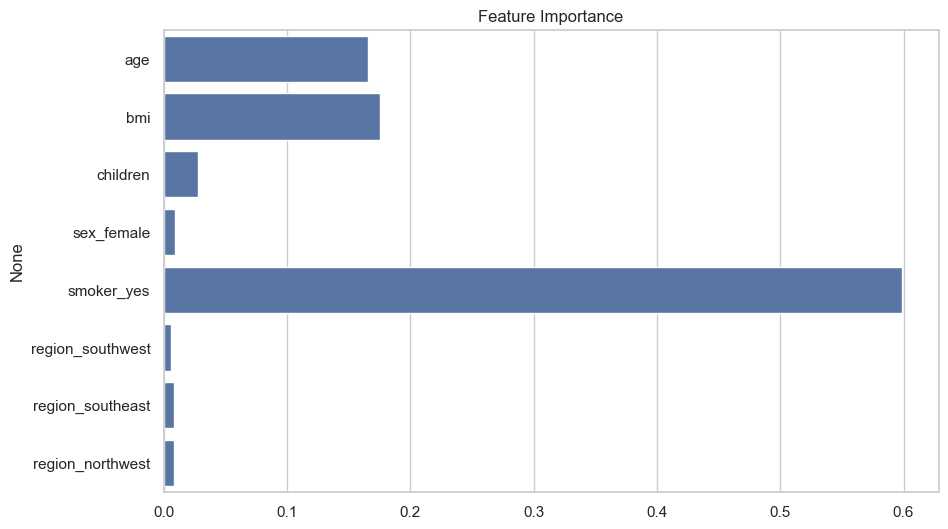

In [34]:
# Feature importance from Random Forest

plt.figure(figsize=(10, 6))
importances = rf.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance")
plt.show()


In [ ]:
# Plot a model to predict insurance charges for a new individual
def predict_insurance_charges(model, input_data):
    input_df = pd.DataFrame([input_data])
    prediction = model.predict(input_df)
    return prediction[0]
# Example input data for a new individual
new_individual = {
    'age':45,
    'bmi':28.99,
    'children':2,
    'sex_female':1,
    'smoker_yes':0,
    'region_southwest':0,
    'region_southeast':1,
    'region_northwest':0,
}                   
predicted_charge = predict_insurance_charges(rf, new_individual)
print(f"Predicted Insurance Charge for the new individual: ${predicted_charge:.2f}")

Predicted Insurance Charge for the new individual: $8888.95


In [ ]:
# Visualize a model to predict insurance charges for a new individual colour smoker status (bar), bmi (line), age (line), sex (bar), region (bar) and children (line) - subplots y=charges

import plotly.graph_objects as go
fig = go.Figure()
fig = go.Figure()

# Add bar for smoker status
fig.add_trace(go.Bar(
    x=['Non-Smoker', 'Smoker'],
    y=[predict_insurance_charges(rf, {**new_individual, 'smoker_yes':0}),
       predict_insurance_charges(rf, {**new_individual, 'smoker_yes':1})],
    name='Smoker Status',
    marker_color=['green', 'red']
))
# Add line for bmi
bmi_values = [18, 22, 25, 30, 35, 40]
fig.add_trace(go.Scatter(
    x=bmi_values,
    y=[predict_insurance_charges(rf, {**new_individual, 'bmi': bmi}) for bmi in bmi_values],
    mode='lines+markers',
    name='BMI',
    line=dict(color='blue')
))
# Add line for age
age_values = [20, 30, 40, 50, 60, 70]
fig.add_trace(go.Scatter(
    x=age_values,
    y=[predict_insurance_charges(rf, {**new_individual, 'age': age}) for age in age_values],
    mode='lines+markers',
    name='Age',
    line=dict(color='orange')
))
# Add bar for sex
fig.add_trace(go.Bar(
    x=['Female', 'Male'],   
    y=[predict_insurance_charges(rf, {**new_individual, 'sex_female': 1}),
       predict_insurance_charges(rf, {**new_individual, 'sex_female': 0})],
    name='Sex',
    marker_color=['pink', 'blue']
))  
# Add bar for region
regions = ['northeast', 'northwest', 'southeast', 'southwest']
fig.add_trace(go.Bar(
    x=regions,
    y=[predict_insurance_charges(rf, {**new_individual,
       'region_northwest': 1 if region == 'northwest' else 0,
       'region_southeast': 1 if region == 'southeast' else 0,
       'region_southwest': 1 if region == 'southwest' else 0}) for region in regions],
    name='Region',
    marker_color=['purple', 'cyan', 'magenta', 'yellow']
))
# Add line for children
children_values = [0, 1, 2, 3, 4, 5]
fig.add_trace(go.Scatter(
    x=children_values,
    y=[predict_insurance_charges(rf, {**new_individual, 'children': children}) for children in children_values],
    mode='lines+markers',
    name='Children',
    line=dict(color='green')
))
fig.update_layout(
    title='Predicted Insurance Charges Based on Individual Features',
    xaxis_title='Feature Values',
    yaxis_title='Predicted Charges',
    barmode='group'
)
fig.show()

---

# 6. Key findings

* Smokers pay more on health insurance that non-smokers
* There is an association between age and insurance charges
* Where one lives does not seem to have any bearing on insurance charges
* Age, smoking status and BMI are key predictors of insurance charges

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create your folder here
  # os.makedirs(name='')
except Exception as e:
  print(e)
